In [1]:
# import time 
# import datetime
# from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import manifold
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit

# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score, f1_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report

from sklearn import tree
from sklearn import ensemble

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import lightgbm as lgb

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from itertools import permutations

# import statsmodels.api as sm

# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dropout
# from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

print("Setup Complete")

Setup Complete


Feature importance CODE : https://www.kaggle.com/code/kimalpha/pump-sensor-data-2-feature-importance

In [2]:
df = pd.read_csv(r'/home/kym/ML/input/ai_nova/pre_sensor.csv')
# df.drop(['Unnamed: 0', 'timestamp'], axis=1, inplace=True)

label_mapping = {
    0.0: 0,
    0.5: 0,
    1: 1
}

df.loc[:, "operation"] = df.operation.map(label_mapping) 
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,operation
0,0,2018-04-01 00:00:00,0.967194,0.830145,0.876660,0.884816,0.792242,0.764598,0.602472,0.683630,...,0.025424,0.027367,0.045424,0.014256,0.133858,0.071489,0.039791,0.245946,0.093853,0
1,1,2018-04-01 00:01:00,0.967194,0.830145,0.876660,0.884816,0.792242,0.764598,0.602472,0.683630,...,0.025424,0.027367,0.045424,0.014256,0.133858,0.071489,0.039791,0.245946,0.093853,0
2,2,2018-04-01 00:02:00,0.959089,0.834736,0.876660,0.890052,0.797904,0.735461,0.598568,0.679645,...,0.024120,0.027367,0.044746,0.013959,0.132874,0.072330,0.039791,0.242162,0.092531,0
3,3,2018-04-01 00:03:00,0.965264,0.830145,0.874763,0.890052,0.784402,0.769891,0.598243,0.688535,...,0.024120,0.026627,0.042712,0.013662,0.130905,0.072330,0.039791,0.242162,0.091870,0
4,4,2018-04-01 00:04:00,0.959475,0.830910,0.876660,0.890052,0.794855,0.765891,0.599870,0.687002,...,0.025424,0.026627,0.044068,0.013365,0.131890,0.074012,0.041885,0.246487,0.091210,0


In [3]:
# label check
df.operation.nunique()

2

## Feature Selection

In [4]:
# Variable 
index = ['index']
time = ['timestamp']
num_variables = ['sensor_00', 'sensor_01', 'sensor_04', 'sensor_06', 'sensor_10']
target = ['operation']

In [5]:
df = df[num_variables + target].copy()
df.head()

,sensor_00,sensor_01,sensor_04,sensor_06,sensor_10,operation
0,0.967194,0.830145,0.792242,0.602472,0.489146,0
1,0.967194,0.830145,0.792242,0.602472,0.489146,0
2,0.959089,0.834736,0.797904,0.598568,0.497561,0
3,0.965264,0.830145,0.784402,0.598243,0.506916,0
4,0.959475,0.830910,0.794855,0.599870,0.518868,0


In [6]:
df.shape

(220320, 6)

In [7]:
df.describe()

,sensor_00,sensor_01,sensor_04,sensor_06,sensor_10,operation
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,0.892365,0.839051,0.737412,0.593382,0.544888,0.000032
std,0.236876,0.058207,0.180685,0.130558,0.158917,0.005637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.949054,0.816373,0.782515,0.598243,0.534839,0.000000
50%,0.963335,0.848508,0.790064,0.612231,0.581963,0.000000
75%,0.980702,0.872226,0.796307,0.653220,0.623654,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## CHECK : Metrics and Scoring (single sensor signal)

In [8]:
X = df.drop(['operation'], axis=1)
y = df['operation']
cols_name = X.columns.tolist()

In [9]:
df_check_pearson = pd.DataFrame(X, columns=cols_name)
df_check_pearson.corr()

,sensor_00,sensor_01,sensor_04,sensor_06,sensor_10
sensor_00,1.000000,0.644321,0.954691,0.843175,0.926760
sensor_01,0.644321,1.000000,0.676792,0.687198,0.596023
sensor_04,0.954691,0.676792,1.000000,0.881080,0.907540
sensor_06,0.843175,0.687198,0.881080,1.000000,0.826103
sensor_10,0.926760,0.596023,0.907540,0.826103,1.000000


Remove features with high correlation.  
Sensor 00 and 04 and 10 are highly correlated. (over 0.90)

* **only use sensor 04, 01, 06** 

In [10]:
feature_selection_variables = ['sensor_01', 'sensor_04', 'sensor_06']

In [11]:
df = df[feature_selection_variables + target].copy()
df.head()

,sensor_01,sensor_04,sensor_06,operation
0,0.830145,0.792242,0.602472,0
1,0.830145,0.792242,0.602472,0
2,0.834736,0.797904,0.598568,0
3,0.830145,0.784402,0.598243,0
4,0.830910,0.794855,0.599870,0


In [12]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

In [13]:
X = df.drop(['operation'], axis=1)
y = df['operation'].astype('int')
cols_name = X.columns.tolist()

In [14]:
class UnivariateFeatureSelection:
    def __init__(self, n_features, problem_type, scoring):
        '''
        :param n_features: real number - SelectPercentile, others - SelectKBest
        :param problem_type: classfication or regression
        :param scoring: name of metric function
        '''
        if problem_type == "classification":
            valid_scoring = {
                            "f_classif": f_classif,
                            "chi2": chi2,
                            "mutual_info_classif": mutual_info_classif
            }
            
        else:
            valid_scoring = {
                            "f_regression": f_regression,
                            "mutual_info_regression": mutual_info_regression
            }
            
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
            
        if isinstance(n_features, int):
            self.selection = SelectKBest(
                            valid_scoring[scoring],
                            k=n_features
            )
            
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                            valid_scoring[scoring],
                            percentile=int(n_features * 100)
            )
            
        else:
            raise Exception("Invalid type of feature")
    
    def fit(self, X, y):
        return self.selection.fit(X, y)
    
    def transform(self, X):
        return self.selection.transform(X)
    
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)

In [15]:
ufs = UnivariateFeatureSelection(
    n_features=3,
    problem_type='classification',
    scoring='f_classif'
)
ufs.fit(X, y)
X_transformed = ufs.transform(X)

In [16]:
type(X_transformed)

numpy.ndarray

In [17]:
y.shape

(220320,)

In [18]:
X_transformed # sensor_04 - 06 - 01

array([[0.83014531, 0.79224211, 0.60247235],
       [0.83014531, 0.79224211, 0.60247235],
       [0.83473604, 0.79790429, 0.59856845],
       ...,
       [0.84085688, 0.78164367, 0.67794401],
       [0.84085688, 0.79383907, 0.67924501],
       [0.84085688, 0.79906572, 0.67924501]])

Feature Importance Ranking :   
    1) Sensor_04  
    2) Sensor_06  
    3) Sensor_01  

## CHECK : Metrics and Scoring (using 1, 2, 3 sensor signal)

In [19]:
# check the no. label 1 
sum(df['operation'] == 1)

7

In [20]:
df["kfold"] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df['operation'].astype('int')
kf = model_selection.StratifiedKFold(n_splits=7)

for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f
        
X = df.drop(['operation'], axis=1)

In [21]:
df.head(1)

,sensor_01,sensor_04,sensor_06,operation,kfold
0,0.856924,0.790209,0.65322,0,0


In [22]:
X.head(1)

,sensor_01,sensor_04,sensor_06,kfold
0,0.856924,0.790209,0.65322,0


In [23]:
def run(fold): 
    global df, X, y
    
    feature_list = []
    final_list = []

    for i in range(1, len(df.columns.tolist())-1): # KFOLD, operation add : -1 (1,2,3) 
        for idx, val in enumerate(list(permutations(cols_name, i))):
            feature_list.append(list(val))
            for v in feature_list:
                if v not in final_list:
                    final_list.append(v)

    final_list = list(set([tuple(set(features)) for features in final_list]))
    
    features_score_list = []

    for j in range(len(final_list)):
        features = list(final_list[j])
        # 다양한 FEATURE 조합의 X 순서대로 돌아옴.
        
        kfold = ['kfold']
        label = ['operation']
        
        temp_df = df[features + label + kfold]
        
        print(f"===={features}====\n")
#         print(df[features])

        cols = [f for f in temp_df.columns if f not in ("operation", "kfold")] # "sensor_00, sensor_01, sensor_06"            
        
#         temp_df.loc[:, cols] = temp_df[cols].astype('float64')
       
        df_train = temp_df[temp_df.kfold != fold].reset_index(drop=True)
        df_valid = temp_df[temp_df.kfold == fold].reset_index(drop=True)
           
        x_train = df_train[cols]
        x_valid = df_valid[cols]
            
        model = xgb.XGBClassifier(random_state=42,
                                  booster='gbtree',
                                  n_jobs=-1,
                                  eval_metric='error',
                                  learning_rate=0.1,
                                  n_estimators=300,
                                  max_depth=5,
                                  reg_lambda=2
                                 )
            
        model.fit(x_train, df_train.operation.values)
            
        valid_preds = model.predict_proba(x_valid)[:, 1]
        valid_auc = metrics.roc_auc_score(df_valid.operation.values, valid_preds)
        print(valid_auc) 
        
#         key = features 
#         value = valid_auc 
        
        features_scores = dict(features=valid_auc)
        features_score_list.append(features_scores)
        
    print(features_score_list)

In [24]:
if __name__ == "__main__":
    for fold_ in range(1):
        run(fold_)

====['sensor_01']====

0.8485734256846921
====['sensor_04']====

0.9772510643705916
====['sensor_06']====

0.17797229459236197
====['sensor_06', 'sensor_01']====

0.7498887971023702
====['sensor_04', 'sensor_01']====

0.9049850670394611
====['sensor_04', 'sensor_06', 'sensor_01']====

0.8753892101417042
====['sensor_04', 'sensor_06']====

0.9558683357692064
[{'features': 0.8485734256846921}, {'features': 0.9772510643705916}, {'features': 0.17797229459236197}, {'features': 0.7498887971023702}, {'features': 0.9049850670394611}, {'features': 0.8753892101417042}, {'features': 0.9558683357692064}]


**Final selected sensor : Sensor_04**

In [25]:
df = pd.read_csv(r'/home/kym/ML/input/ai_nova/pre_sensor.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
final_feature = ['sensor_04']

In [26]:
df = df[final_feature + target].copy()
df.head()

,sensor_04,operation
0,0.792242,0.0
1,0.792242,0.0
2,0.797904,0.0
3,0.784402,0.0
4,0.794855,0.0


In [27]:
df.operation.nunique()

3

## Feature Extension

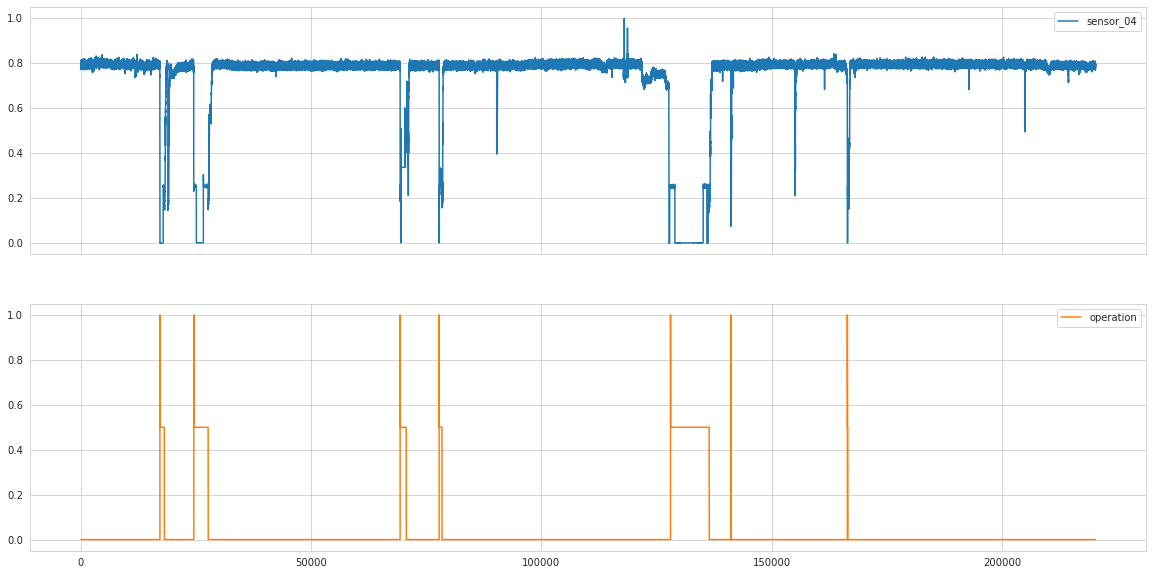

In [28]:
df.plot(subplots=True, sharex=True, figsize=(20,10))
plt.show()

In [29]:
# Dimension reduction Visualization (TSNE)

tsne = manifold.TSNE(n_components=2, random_state=42)
transformed_df = tsne.fit_transform(df)

tsne_df = pd.DataFrame(np.column_stack((transformed_df, df.operation)),
                      columns=['X', 'y', 'operation']
                      )
tsne_df.loc[:, 'operation'] = tsne_df['operation'].astype(float)

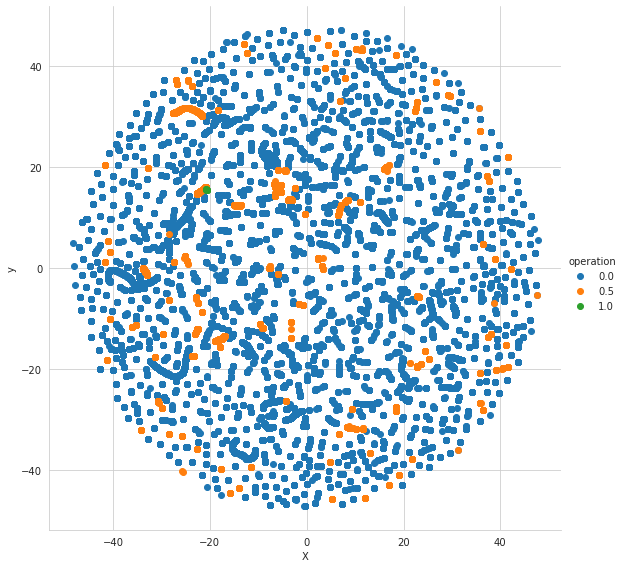

In [30]:
# Cluster Visualization 

grid = sns.FacetGrid(tsne_df, hue='operation', size=8)
grid.map(plt.scatter, "X", 'y').add_legend()

In [31]:
df = pd.read_csv(r'/home/kym/ML/input/ai_nova/pre_sensor.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.reset_index(inplace=True)

# Variable 
index = ['index']
time = ['timestamp']
num_variables = ['sensor_04']
target = ['operation']

df = df[index + time + final_feature + target].copy()
df.head(1)

,index,timestamp,sensor_04,operation
0,0,2018-04-01 00:00:00,0.792242,0.0


In [32]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [33]:
from sklearn.pipeline import make_pipeline

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.distribution import MultiprocessingDistributor

from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

In [34]:
df.head(1)

,index,timestamp,sensor_04,operation
0,0,2018-04-01,0.792242,0.0


In [35]:
X = extract_features(df.drop(['operation'], axis=1),
                    column_id='index', column_sort='timestamp',
                    column_value='sensor_04',
                    impute_function=impute, show_warnings=False)
X.head()

Feature Extraction: 100%|███████████████████████| 60/60 [04:49<00:00,  4.82s/it]


,sensor_04__variance_larger_than_standard_deviation,sensor_04__has_duplicate_max,sensor_04__has_duplicate_min,sensor_04__has_duplicate,sensor_04__sum_values,sensor_04__abs_energy,sensor_04__mean_abs_change,sensor_04__mean_change,sensor_04__mean_second_derivative_central,sensor_04__median,...,sensor_04__permutation_entropy__dimension_6__tau_1,sensor_04__permutation_entropy__dimension_7__tau_1,sensor_04__query_similarity_count__query_None__threshold_0.0,"sensor_04__matrix_profile__feature_""min""__threshold_0.98","sensor_04__matrix_profile__feature_""max""__threshold_0.98","sensor_04__matrix_profile__feature_""mean""__threshold_0.98","sensor_04__matrix_profile__feature_""median""__threshold_0.98","sensor_04__matrix_profile__feature_""25""__threshold_0.98","sensor_04__matrix_profile__feature_""75""__threshold_0.98",sensor_04__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,0.792242,0.627648,0.0,0.0,0.0,0.792242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.792242,0.627648,0.0,0.0,0.0,0.792242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.797904,0.636651,0.0,0.0,0.0,0.797904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.784402,0.615287,0.0,0.0,0.0,0.784402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.794855,0.631795,0.0,0.0,0.0,0.794855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X.shape

(220320, 789)

In [37]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "detect_seq"
X.head()

TypeError: 'int' object is not subscriptable

In [ ]:
# window_size = 30 (30 min)
df_rolled = roll_time_series(df, column_id='Symbols', 
                            column_sort='timestamp',
                            max_timeshift=30)
df_rolled.head()

In [ ]:
X = extract_features(X[X["index"] == 0], column_id='index', column_sort='timestamp', n_jobs=20, impute_function=impute)

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                   test_size=0.3,
                                                                   shuffle=False,
                                                                   random_state=42)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:
print(y_train.nunique())
print(y_test.nunique())

In [ ]:
df.head(10)

In [ ]:
# extraction_settings = ComprehensiveFCParameters()
# X = extract_features(df, column_sort='timestamp' )

In [ ]:
# from tsfresh.feature_extraction import feature_calculators as fc

# df['abs_energy'] = fc.abs_energy(df.sensor_04)
# df['count_above_mean'] = fc.count_above_mean(df.sensor_04)
# df['count_below_mean'] = fc.count_below_mean(df.sensor_04)
# df['mean_abs_change'] = fc.mean_abs_change(df.sensor_04)
# df['mean_change'] = fc.mean_change(df.sensor_04)

# df.describe()

In [ ]:


# tsfresh = TSFreshFeatureExtractor(default_fc_parameters='efficient', show_warnings=False, n_jobs=20)
# df_tsf_x_train = tsfresh.fit_transform(x_train)
# df_tsf_x_train.head()
# df_extracted_features = extract_features(df, column_id='index', column_sort='timestamp' )

In [ ]:
df_tsf_x_train.shape

In [ ]:
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes

# fetch dataset from uci
download_har_dataset()

In [ ]:
df = load_har_dataset()
df.head()

In [ ]:
print(df.info())
print(df.shape)

In [ ]:
y = load_har_classes()
y

In [ ]:
y.nunique() # 0,1,2,3,4,5

In [ ]:
df['id'] = df.index
df = df.melt(id_vars='id', var_name="time").sort_values(["id", "time"]).reset_index(drop=True)
df.head()

In [ ]:
df.shape

In [ ]:
df['id'].nunique()

In [ ]:
plt.title('accelerometer reading')
plt.plot(df[df["id"] == 0].set_index("time").value)
plt.show()

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
X = extract_features(df[df["id"] < 500], column_id='id', column_sort='time', impute_function=impute)
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y[:500], test_size=.2)

In [ ]:
cf = DecisionTreeClassifier()
cf.fit(X_train, y_train)
print(classification_report(y_test, cf.predict(X_test)))